In [1]:
import numpy as np
from IPython import get_ipython
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray

In [2]:
def criar_elemento_estruturante(
    coord_central: tuple[int, int],
    formato: np.ndarray,
    distancia_maxima_x: int,
    distancia_maxima_y: int,
    valor_padrao: int,
) -> dict:
    """
    Cria e retorna um dicionário que representa um elemento estrutural.

    Parâmetros:
      coord_central (tuple[int, int]): Coordenadas do centro do elemento.
      formato (np.ndarray): Array que define o formato do elemento.
      distancia_maxima_x (int): Distância máxima em relação ao centro no eixo X.
      distancia_maxima_y (int): Distância máxima em relação ao centro no eixo Y.
      valor_padrao (int): Valor a ser usado para indicar a intensidade ou marcação.

    Retorna:
      dict: Estrutura contendo as informações do elemento.
    """
    elemento = {
        "coord_central": coord_central,
        "formato": formato,
        "distancia_maxima_x": distancia_maxima_x,
        "distancia_maxima_y": distancia_maxima_y,
        "valor": valor_padrao,
    }
    # Abaixo podem ser inseridas outras operações que envolvam o elemento estrutural.
    return elemento

In [3]:
def erosao(imagem: np.ndarray, elemento_estruturante: dict) -> np.ndarray:
    """
    Executa a operação de erosão em uma imagem binária (imagem), com base nas
    informações de um elemento estrutural (elemento_estruturante).

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      elemento_estruturante (dict): Dicionário contendo:
        - 'coord_central' (tuple[int, int]): Centro do elemento estrutural.
        - 'formato' (np.ndarray): Formato do elemento estrutural.
        - 'distancia_maxima_x' (int): Distância máxima no eixo X.
        - 'distancia_maxima_y' (int): Distância máxima no eixo Y.
        - 'valor' (int): Valor associado ao elemento estrutural (geralmente 1 ou 255).

    Retorna:
      np.ndarray: Imagem resultante após a erosão.
    """
    distancia_x = elemento_estruturante["distancia_maxima_x"]
    distancia_y = elemento_estruturante["distancia_maxima_y"]

    # Cria uma nova dimensão para aplicar padding à imagem
    nova_dimensao = (
        imagem.shape[0] + 2 * distancia_x,
        imagem.shape[1] + 2 * distancia_y,
    )

    # Arrays para armazenar a imagem com padding e o resultado provisório
    imagem_preenchida = np.zeros(nova_dimensao, dtype=imagem.dtype)
    imagem_erosao = np.zeros(nova_dimensao, dtype=imagem.dtype)

    # Posiciona a imagem original dentro do array com padding
    imagem_preenchida[
        distancia_x : distancia_x + imagem.shape[0],
        distancia_y : distancia_y + imagem.shape[1],
    ] = imagem

    # Percorre cada posição válida para aplicar o elemento estrutural
    for x in range(distancia_x, distancia_x + imagem.shape[0] - 1):
        for y in range(distancia_y, distancia_y + imagem.shape[1] - 1):
            x_inicial = x - elemento_estruturante["coord_central"][0]
            x_final = x_inicial + elemento_estruturante["formato"].shape[0]
            y_inicial = y - elemento_estruturante["coord_central"][1]
            y_final = y_inicial + elemento_estruturante["formato"].shape[1]

            # Extrai a fatia da imagem que será comparada com o formato
            fatia = imagem_preenchida[x_inicial:x_final, y_inicial:y_final]

            # Verifica se todos os pixels dentro do formato correspondem ao valor esperado
            imagem_erosao[x, y] = (
                fatia * elemento_estruturante["formato"]
            ).sum() == elemento_estruturante["valor"]

    # Retorna somente a porção central da imagem (removendo o padding)
    return imagem_erosao[
        distancia_x : distancia_x + imagem.shape[0],
        distancia_y : distancia_y + imagem.shape[1],
    ]

In [4]:
def dilatacao(imagem: np.ndarray, elemento_estruturante: dict) -> np.ndarray:
    """
    Executa a operação de dilatação em uma imagem binária (imagem), usando
    as informações de um elemento estrutural (elemento_estruturante).

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      elemento_estruturante (dict): Dicionário contendo:
        - 'coord_central' (tuple[int, int]): Centro do elemento estrutural.
        - 'formato' (np.ndarray): Formato do elemento estrutural.
        - 'distancia_maxima_x' (int): Distância máxima no eixo X.
        - 'distancia_maxima_y' (int): Distância máxima no eixo Y.
        - 'valor' (int): Valor associado ao elemento estrutural (geralmente 1 ou 255).

    Retorna:
      np.ndarray: Imagem resultante após a dilatação.
    """
    distancia_x = elemento_estruturante["distancia_maxima_x"]
    distancia_y = elemento_estruturante["distancia_maxima_y"]

    # Cria uma nova dimensão para aplicar padding à imagem
    nova_dimensao = (
        imagem.shape[0] + 2 * distancia_x,
        imagem.shape[1] + 2 * distancia_y,
    )

    # Arrays para armazenar a imagem com padding e o resultado provisório
    imagem_preenchida = np.zeros(nova_dimensao, dtype=imagem.dtype)
    imagem_dilatada = np.zeros(nova_dimensao, dtype=imagem.dtype)

    # Posiciona a imagem original dentro do array com padding
    imagem_preenchida[
        distancia_x : distancia_x + imagem.shape[0],
        distancia_y : distancia_y + imagem.shape[1],
    ] = imagem

    # Percorre cada posição válida para aplicar o elemento estrutural
    for x in range(distancia_x, distancia_x + imagem.shape[0] - 1):
        for y in range(distancia_y, distancia_y + imagem.shape[1] - 1):
            x_inicial = x - elemento_estruturante["coord_central"][0]
            x_final = x_inicial + elemento_estruturante["formato"].shape[0]
            y_inicial = y - elemento_estruturante["coord_central"][1]
            y_final = y_inicial + elemento_estruturante["formato"].shape[1]

            # Extrai a fatia da imagem que será comparada com o formato
            fatia = imagem_preenchida[x_inicial:x_final, y_inicial:y_final]

            # A dilatação ocorre se houver interseção entre a fatia
            # e o elemento estrutural (qualquer valor diferente de 0)
            imagem_dilatada[x, y] = (
                fatia * elemento_estruturante["formato"]
            ).sum() != 0

    # Retorna somente a porção central da imagem (removendo o padding)
    return imagem_dilatada[
        distancia_x : distancia_x + imagem.shape[0],
        distancia_y : distancia_y + imagem.shape[1],
    ]

In [5]:
def abertura(imagem: np.ndarray, elemento_estruturante: dict) -> np.ndarray:
    """
    Executa a operação de abertura em uma imagem binária (imagem), combinando
    as operações de erosão e dilatação com o mesmo elemento estrutural.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      elemento_estruturante (dict): Dicionário contendo:
        - 'coord_central' (tuple[int, int]): Centro do elemento estrutural.
        - 'formato' (np.ndarray): Formato do elemento estrutural.
        - 'distancia_maxima_x' (int): Distância máxima no eixo X.
        - 'distancia_maxima_y' (int): Distância máxima no eixo Y.
        - 'valor' (int): Valor associado ao elemento estrutural (geralmente 1 ou 255).

    Retorna:
      np.ndarray: Imagem resultante após a abertura.
    """
    # Primeiro, executa a erosão
    imagem_pos_erosao = erosao(imagem, elemento_estruturante)
    # Em seguida, faz a dilatação
    imagem_abertura = dilatacao(imagem_pos_erosao, elemento_estruturante)
    return imagem_abertura

In [6]:
def fechamento(imagem: np.ndarray, elemento_estruturante: dict) -> np.ndarray:
    """
    Executa a operação de fechamento em uma imagem binária (imagem), combinando
    as operações de dilatação e erosão com o mesmo elemento estrutural.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      elemento_estruturante (dict): Dicionário contendo:
        - 'coord_central' (tuple[int, int]): Centro do elemento estrutural.
        - 'formato' (np.ndarray): Formato do elemento estrutural.
        - 'distancia_maxima_x' (int): Distância máxima no eixo X.
        - 'distancia_maxima_y' (int): Distância máxima no eixo Y.
        - 'valor' (int): Valor associado ao elemento estrutural (geralmente 1 ou 255).

    Retorna:
      np.ndarray: Imagem resultante após o fechamento.
    """
    # Primeiro, executa a dilatação
    imagem_pos_dilatacao = dilatacao(imagem, elemento_estruturante)
    # Em seguida, faz a erosão
    imagem_fechamento = erosao(imagem_pos_dilatacao, elemento_estruturante)
    return imagem_fechamento

In [7]:
def erosao_cinza(imagem: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executa a operação de erosão em uma imagem em tons de cinza (imagem),
    usando um kernel que representa o elemento estrutural.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      kernel (np.ndarray): Array bidimensional que define o formato
                           do elemento estrutural (valores > 0 representam
                           os pontos ativos do kernel).

    Retorna:
      np.ndarray: Imagem resultante após a erosão em tons de cinza.
    """
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2

    # Aplica padding ao redor da imagem para lidar com bordas
    # usando o modo 'edge' para replicar os valores da borda.
    imagem_preenchida = np.pad(imagem, ((pad_h, pad_h), (pad_w, pad_w)), mode="edge")

    # Cria um array para armazenar o resultado
    imagem_erosao = np.zeros_like(imagem)

    # Percorre cada pixel da imagem original
    for i in range(imagem.shape[0]):
        for j in range(imagem.shape[1]):
            # Extrai a região que será comparada com o kernel
            regiao = imagem_preenchida[i : i + kH, j : j + kW]

            # Considera apenas os pixels onde o kernel é não-zero
            # (para um elemento estrutural "flat", todos os valores > 0)
            pixels_validos = regiao[kernel > 0]

            # Atribui o valor mínimo desses pixels ao pixel resultante
            imagem_erosao[i, j] = np.min(pixels_validos)

    return imagem_erosao

In [8]:
def dilatacao_cinza(imagem: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executa a operação de dilatação em uma imagem em tons de cinza (imagem),
    usando um kernel que representa o elemento estrutural.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      kernel (np.ndarray): Array bidimensional que define o formato
                           do elemento estrutural (valores > 0 representam
                           os pontos ativos do kernel).

    Retorna:
      np.ndarray: Imagem resultante após a dilatação em tons de cinza.
    """
    kH, kW = kernel.shape
    pad_h = kH // 2
    pad_w = kW // 2

    # Aplica padding ao redor da imagem para lidar com bordas
    # usando o modo 'edge' para replicar os valores da borda.
    imagem_preenchida = np.pad(imagem, ((pad_h, pad_h), (pad_w, pad_w)), mode="edge")

    # Cria um array para armazenar o resultado
    imagem_dilatada = np.zeros_like(imagem)

    # Percorre cada pixel da imagem original
    for i in range(imagem.shape[0]):
        for j in range(imagem.shape[1]):
            # Extrai a região que será comparada com o kernel
            regiao = imagem_preenchida[i : i + kH, j : j + kW]

            # Considera apenas os pixels onde o kernel é não-zero
            pixels_validos = regiao[kernel > 0]

            # Atribui o valor máximo desses pixels ao pixel resultante
            imagem_dilatada[i, j] = np.max(pixels_validos)

    return imagem_dilatada

In [9]:
def abertura_cinza(imagem: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executa a operação de abertura (erosão seguida de dilatação) em uma
    imagem em tons de cinza, usando o mesmo kernel para ambas as etapas.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      kernel (np.ndarray): Array bidimensional que define o formato
                           do elemento estrutural (valores > 0 representam
                           os pontos ativos do kernel).

    Retorna:
      np.ndarray: Imagem resultante após a abertura em tons de cinza.
    """
    ipy = get_ipython()

    imagem_pos_erosao = erosao_cinza(imagem, kernel)
    imagem_abertura = dilatacao_cinza(imagem_pos_erosao, kernel)
    return imagem_abertura

In [10]:
def fechamento_cinza(imagem: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    """
    Executa a operação de fechamento (dilatação seguida de erosão) em uma
    imagem em tons de cinza, usando o mesmo kernel para ambas as etapas.

    Parâmetros:
      imagem (np.ndarray): Array bidimensional que representa a imagem.
      kernel (np.ndarray): Array bidimensional que define o formato
                           do elemento estrutural (valores > 0 representam
                           os pontos ativos do kernel).

    Retorna:
      np.ndarray: Imagem resultante após o fechamento em tons de cinza.
    """
    ipy = get_ipython()
    
    imagem_pos_dilatacao = dilatacao_cinza(imagem, kernel)
    imagem_fechamento = erosao_cinza(imagem_pos_dilatacao, kernel)
    return imagem_fechamento

In [11]:
def disco_estruturante(formato: tuple[int, int]) -> np.ndarray:
    """
    Cria e retorna um elemento estrutural no formato de disco.

    Parâmetros:
      formato (tuple[int, int]): Tamanho (altura, largura) do array
                                 que representará o disco.

    Retorna:
      np.ndarray: Array binário (0 e 1) em formato de disco, onde 1
                  representa os pixels que pertencem ao disco.
    """
    disco = np.zeros(formato, dtype=np.uint8)
    raio = min(formato[0], formato[1]) // 2

    for i in range(formato[0]):
        for j in range(formato[1]):
            # Verifica se o ponto (i, j) está dentro do raio
            distancia_ao_centro = (i - formato[0] // 2) ** 2 + (
                j - formato[1] // 2
            ) ** 2
            if distancia_ao_centro <= raio * raio:
                disco[i, j] = 1

    return disco

In [12]:
def carregar_imagem_preto_e_branco(caminho_imagem: str):
    """
    Lê uma imagem a partir de um arquivo e converte para escala de cinza.

    Parâmetros:
      caminho_imagem (str): Caminho para a imagem (por exemplo: 'image_0001.jpg').

    Retorna:
      np.ndarray: Imagem em escala de cinza normalizada (valores entre 0 e 1).
    """
    imagem = imread(caminho_imagem)  # Carrega a imagem
    imagem_cinza = rgb2gray(imagem)  # Converte para tons de cinza
    return imagem_cinza

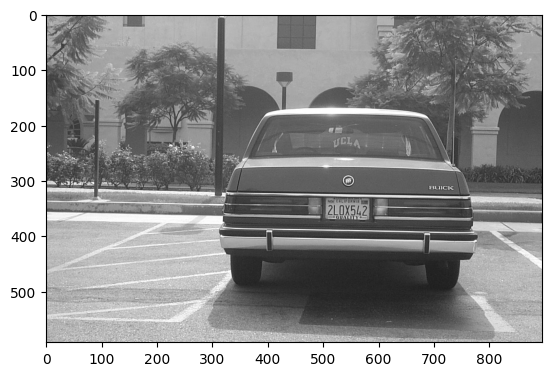

In [13]:
carro = carregar_imagem_preto_e_branco("imagens/image_0001.jpg")
plt.imshow(carro, cmap="gray")
plt.show()

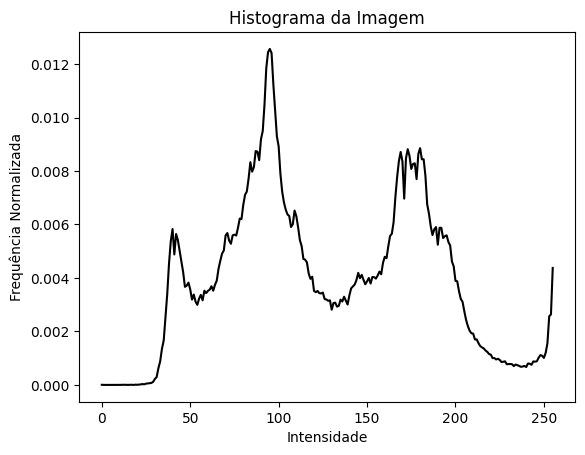

In [14]:
h, _ = np.histogram(carro, bins=256)
h = h.astype(float) / (carro.shape[0] * carro.shape[1])

plt.plot(h, "-k")
plt.title("Histograma da Imagem")
plt.xlabel("Intensidade")
plt.ylabel("Frequência Normalizada")
plt.show()

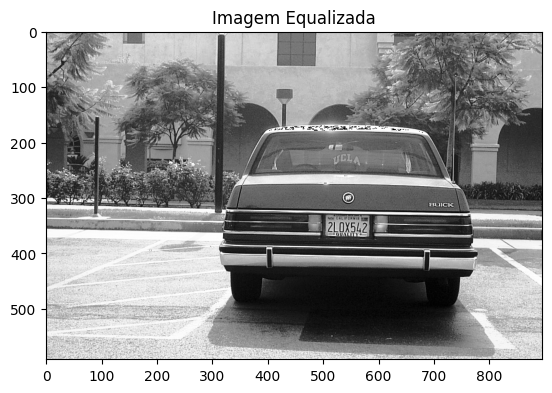

In [15]:
# Calcula a função de mapeamento (Look-Up Table) a partir da distribuição acumulada
T = (np.cumsum(h) * 256).astype("uint8")

# Cria uma imagem para armazenar o resultado
eq_carro = np.zeros(carro.shape, dtype=np.uint8)

# Percorre cada pixel da imagem para aplicar o mapeamento
for i in range(carro.shape[0]):
    for j in range(carro.shape[1]):
        # Multiplica por 255 para usar como índice (pois 'carro' está em 0..1)
        indice = int(carro[i, j] * 255)
        eq_carro[i, j] = T[indice]

# Exibe a imagem equalizada
plt.imshow(eq_carro, cmap="gray")
plt.title("Imagem Equalizada")
plt.show()

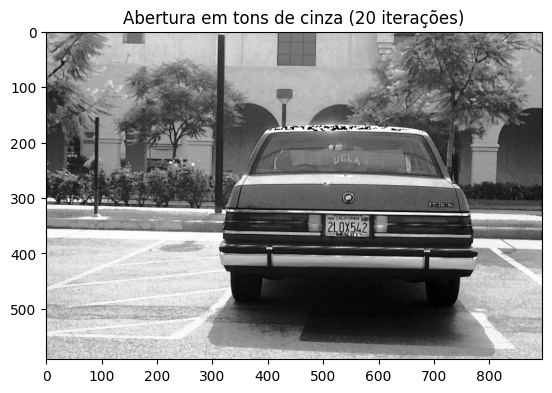

In [16]:
# Cria um kernel em formato de disco com tamanho 3×3
kernel = disco_estruturante((3, 3))

# Copia a imagem equalizada antes de aplicar a transformação
resultado = eq_carro.copy()

# Aplica a operação de abertura repetidamente (20 iterações)
for _ in range(20):
    # Abertura = erosão + dilatação em nível de cinza
    resultado = erosao_cinza(resultado, kernel)
    resultado = dilatacao_cinza(resultado, kernel)

# Exibe o resultado final
plt.imshow(resultado, cmap="gray")
plt.title("Abertura em tons de cinza (20 iterações)")
plt.show()